In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK'] ='True'

In [3]:
def data_loading(train_batches, test_batches):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize((32, 32)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batches=train_batches, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batches=test_batches, shuffle=True)

    return (train_loader, test_loader)

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        # flatten as one dimension
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
train_batches = 64
test_batches = 1000
train_loader, test_loader = data_loading(train_batches, test_batches)

In [7]:
def train(model, opt, epoch, train_loader, log_interval):
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    n_correct = 0
    train_loss = 0
    counter = 0
    n_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        counter += 1
        data, target = Variable(data), Variable(target)
        opt.zero_grad()

        # Forward propagation
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        opt.step()

        train_loss += loss.data

        pred = np.argmax(output.data, axis=1)
        n_samples += target.size(0)
        n_correct += (pred == target).sum().item()
        acc = 100.0 * n_correct / n_samples

        # print log
        if batch_idx % log_interval == 0:
            print('Train set, Epoch {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                loss.data))
            print("Train Accuracy: ", round(acc,2))
    train_loss /= counter
    return train_loss, round(acc,2)


In [8]:
def test(model, epoch, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        
        output = model(data)
        test_loss += loss_fn(output, target).data

        pred = np.argmax(output.data, axis=1)
        correct = correct + np.equal(pred, target.data).sum()

    # Print log
    test_loss /= len(test_loader.dataset)
    print('\nTest set, Epoch {} , Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
torch.manual_seed(1)
model= LeNet()

lr = 0.015
momentum = 0.5
opt = optim.SGD(model.parameters(), lr, momentum)
m0_arr_of_losses = []
m0_acc_arr = []

epochs = 100
log_interval = 200
for epoch in range(1, epochs + 1):
    loss, acc = train(model, opt, epoch, train_loader, log_interval)
    m0_arr_of_losses.append(loss)
    m0_acc_arr.append(acc)
    test(model, epoch, test_loader)

Train set, Epoch 1 [0/60000]	Loss: 2.322258
Train Accuracy:  10.94
Train set, Epoch 1 [12800/60000]	Loss: 0.308483
Train Accuracy:  57.04
Train set, Epoch 1 [25600/60000]	Loss: 0.296368
Train Accuracy:  73.06
Train set, Epoch 1 [38400/60000]	Loss: 0.246842
Train Accuracy:  79.78
Train set, Epoch 1 [51200/60000]	Loss: 0.201745
Train Accuracy:  83.63


/Users/pandu/anaconda3/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set, Epoch 1 , Average loss: 0.0987, Accuracy: 9709/10000 (97%)

Train set, Epoch 2 [0/60000]	Loss: 0.111173
Train Accuracy:  93.75
Train set, Epoch 2 [12800/60000]	Loss: 0.077340
Train Accuracy:  96.35
Train set, Epoch 2 [25600/60000]	Loss: 0.326990
Train Accuracy:  96.54
Train set, Epoch 2 [38400/60000]	Loss: 0.082683
Train Accuracy:  96.74
Train set, Epoch 2 [51200/60000]	Loss: 0.084825
Train Accuracy:  96.9

Test set, Epoch 2 , Average loss: 0.0699, Accuracy: 9758/10000 (98%)

Train set, Epoch 3 [0/60000]	Loss: 0.032016
Train Accuracy:  100.0
Train set, Epoch 3 [12800/60000]	Loss: 0.070410
Train Accuracy:  97.9
Train set, Epoch 3 [25600/60000]	Loss: 0.054225
Train Accuracy:  97.81
Train set, Epoch 3 [38400/60000]	Loss: 0.018680
Train Accuracy:  97.89
Train set, Epoch 3 [51200/60000]	Loss: 0.051565
Train Accuracy:  97.91

Test set, Epoch 3 , Average loss: 0.0548, Accuracy: 9829/10000 (98%)

Train set, Epoch 4 [0/60000]	Loss: 0.095980
Train Accuracy:  96.88
Train set, Epoch 4 [

In [10]:
torch.manual_seed(1)

model_1= CNN()

lr = 0.01
momentum = 0.5
opt = optim.SGD(model_1.parameters(), lr=lr, momentum=momentum)
m1_arr_of_losses = []
m1_acc_arr = []

epochs = 100
log_interval = 100
for epoch in range(1, epochs + 1):
    loss, acc = train(model_1, opt, epoch, train_loader, log_interval=log_interval)
    m1_arr_of_losses.append(loss)
    m1_acc_arr.append(acc)
    test(model_1, epoch, test_loader)

Train set, Epoch 1 [0/60000]	Loss: 2.325572
Train Accuracy:  3.12
Train set, Epoch 1 [6400/60000]	Loss: 1.379374
Train Accuracy:  27.03
Train set, Epoch 1 [12800/60000]	Loss: 0.967496
Train Accuracy:  47.64
Train set, Epoch 1 [19200/60000]	Loss: 0.629883
Train Accuracy:  58.59
Train set, Epoch 1 [25600/60000]	Loss: 0.403531
Train Accuracy:  65.14
Train set, Epoch 1 [32000/60000]	Loss: 0.264781
Train Accuracy:  69.5
Train set, Epoch 1 [38400/60000]	Loss: 0.598071
Train Accuracy:  72.81
Train set, Epoch 1 [44800/60000]	Loss: 0.324445
Train Accuracy:  75.37
Train set, Epoch 1 [51200/60000]	Loss: 0.277097
Train Accuracy:  77.33
Train set, Epoch 1 [57600/60000]	Loss: 0.454994
Train Accuracy:  78.98

Test set, Epoch 1 , Average loss: 0.1262, Accuracy: 9612/10000 (96%)

Train set, Epoch 2 [0/60000]	Loss: 0.195676
Train Accuracy:  95.31
Train set, Epoch 2 [6400/60000]	Loss: 0.126905
Train Accuracy:  93.07
Train set, Epoch 2 [12800/60000]	Loss: 0.213336
Train Accuracy:  93.2
Train set, Epoch 2 

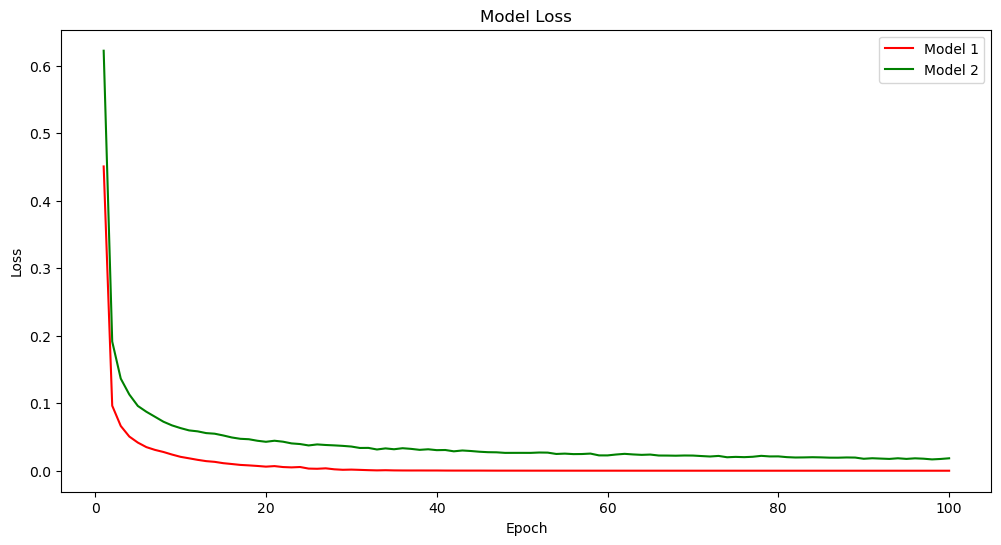

In [12]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1, 101, 1), m0_arr_of_losses, color = "r")
plt.plot(np.arange(1, 101, 1), m1_arr_of_losses, color = "g")
plt.title('Model Loss')
plt.legend(['Model 1', 'Model 2'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


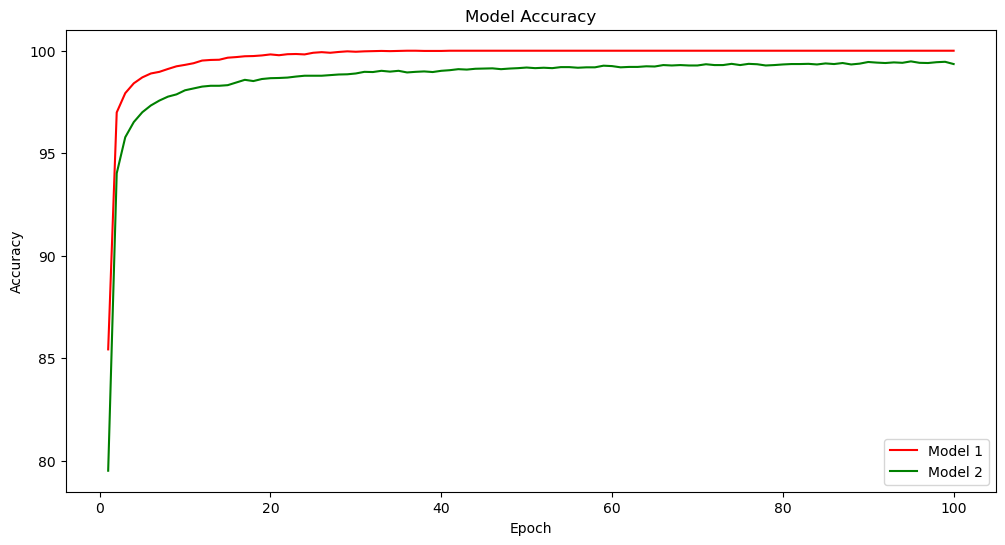

In [13]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1, 101, 1), m0_acc_arr, color = "r")
plt.plot(np.arange(1, 101, 1), m1_acc_arr, color = "g")
plt.title('Model Accuracy')
plt.legend(['Model 1', 'Model 2'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()